<a href="https://colab.research.google.com/github/dchatterjee/vision.depth-estimation/blob/main/TRI_PackNet_SFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/TRI-ML/packnet-sfm.git
%cd packnet-sfm

Cloning into 'packnet-sfm'...
remote: Enumerating objects: 639, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 639 (delta 75), reused 69 (delta 69), pack-reused 521
Receiving objects: 100% (639/639), 26.43 MiB | 31.01 MiB/s, done.
Resolving deltas: 100% (265/265), done.
/content/packnet-sfm


In [2]:
!pip install yacs
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=20ab400d1a3bf65ac9f9b42e41d36f7f653716ab70cf64d220815d84c73551a2
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
%set_env PYTHONPATH=/content/packnet-sfm/packnet_sfm:/env/python

env: PYTHONPATH=/content/packnet-sfm/packnet_sfm:/env/python


In [4]:
!mkdir ./checkpoints
checkpoints_dir = './checkpoints'

In [38]:
!mkdir ./input
!mkdir ./output
image_input_dir = './input'
image_output_dir = './output'

mkdir: cannot create directory ‘./output’: File exists


In [6]:
import os
import shutil
from google.colab import files

def upload_files(upload_path):
  uploaded = files.upload()
  for filename, content in uploaded.items():
    dst_path = os.path.join(upload_path, filename)
    shutil.move(filename, dst_path)
  return list(uploaded.keys())

In [7]:
import numpy as np
import torch

from glob import glob
from cv2 import imwrite

from packnet_sfm.models.model_wrapper import ModelWrapper
from packnet_sfm.datasets.augmentations import resize_image, to_tensor
from packnet_sfm.utils.horovod import hvd_init, rank, world_size, print0
from packnet_sfm.utils.image import load_image
from packnet_sfm.utils.config import parse_test_file
from packnet_sfm.utils.load import set_debug
from packnet_sfm.utils.depth import write_depth, inv2depth, viz_inv_depth
from packnet_sfm.utils.logging import pcolor


def is_image(file, ext=('.png', '.jpg',)):
    """Check if a file is an image with certain extensions"""
    return file.endswith(ext)

@torch.no_grad()
def infer_and_save_depth(input_file, output_file, model_wrapper, image_shape, half, save):
    """
    Process a single input file to produce and save visualization

    Parameters
    ----------
    input_file : str
        Image file
    output_file : str
        Output file, or folder where the output will be saved
    model_wrapper : nn.Module
        Model wrapper used for inference
    image_shape : Image shape
        Input image shape
    half: bool
        use half precision (fp16)
    save: str
        Save format (npz or png)
    """
    if not is_image(output_file):
        # If not an image, assume it's a folder and append the input name
        os.makedirs(output_file, exist_ok=True)
        output_file = os.path.join(output_file, os.path.basename(input_file))

    # change to half precision for evaluation if requested
    dtype = torch.float16 if half else None

    # Load image
    image = load_image(input_file)
    # Resize and to tensor
    image = resize_image(image, image_shape)
    image = to_tensor(image).unsqueeze(0)

    # Send image to GPU if available
    if torch.cuda.is_available():
        image = image.to('cuda:{}'.format(rank()), dtype=dtype)

    # Depth inference (returns predicted inverse depth)
    pred_inv_depth = model_wrapper.depth(image)['inv_depths'][0]

    if save == 'npz' or save == 'png':
        # Get depth from predicted depth map and save to different formats
        filename = '{}.{}'.format(os.path.splitext(output_file)[0], save)
        print('Saving {} to {}'.format(
            pcolor(input_file, 'cyan', attrs=['bold']),
            pcolor(filename, 'magenta', attrs=['bold'])))
        write_depth(filename, depth=inv2depth(pred_inv_depth))
    else:
        # Prepare RGB image
        rgb = image[0].permute(1, 2, 0).detach().cpu().numpy() * 255
        # Prepare inverse depth
        viz_pred_inv_depth = viz_inv_depth(pred_inv_depth[0]) * 255
        # Concatenate both vertically
        image = np.concatenate([rgb, viz_pred_inv_depth], 0)
        # Save visualization
        print('Saving {} to {}'.format(
            pcolor(input_file, 'cyan', attrs=['bold']),
            pcolor(output_file, 'magenta', attrs=['bold'])))
        imwrite(output_file, image[:, :, ::-1])


In [8]:
def do_inference(checkpoint, input, output, image_shape=None, half=None, save=None):

    # Initialize horovod
    hvd_init()

    # Parse the checkpoint file
    config, state_dict = parse_test_file(checkpoint)

    # If no image shape is provided, use the checkpoint one
    if image_shape is None:
        image_shape = config.datasets.augmentation.image_shape

    # Set debug if requested
    set_debug(config.debug)

    # Initialize model wrapper from checkpoint arguments
    model_wrapper = ModelWrapper(config, load_datasets=False)
    # Restore monodepth_model state
    model_wrapper.load_state_dict(state_dict)

    # change to half precision for evaluation if requested
    if half == "No":
        half = False
    dtype = torch.float16 if half else None

    # Send model to GPU if available
    if torch.cuda.is_available():
        model_wrapper = model_wrapper.to('cuda:{}'.format(rank()), dtype=dtype)

    # Set to eval mode
    model_wrapper.eval()

    if os.path.isdir(input):
        # If input file is a folder, search for image files
        files = []
        for ext in ['png', 'jpg']:
            files.extend(glob((os.path.join(input, '*.{}'.format(ext)))))
        files.sort()
        print0('Found {} files'.format(len(files)))
    else:
        # Otherwise, use it as is
        files = [input]

    # Process each file
    for fn in files[rank()::world_size()]:
        infer_and_save_depth(
            fn, output, model_wrapper, image_shape, half, save)

In [9]:
checkpoint_dict = {
    "ResNet18 Self-Supervised 384x640 ImageNet DDAD": "https://tri-ml-public.s3.amazonaws.com/github/packnet-sfm/models/ResNet18_MR_selfsup_D.ckpt", 
    "PackNet Self-Supervised 384x640 DDAD": "https://tri-ml-public.s3.amazonaws.com/github/packnet-sfm/models/PackNet01_MR_selfsup_D.ckpt", 
    "PackNetSAN Supervised 384x640 DDAD": "https://tri-ml-public.s3.amazonaws.com/github/packnet-sfm/models/PackNetSAN01_HR_sup_D.ckpt",
    "ResNet18 Self-Supervised 192x640 ImageNet KITTI": "https://tri-ml-public.s3.amazonaws.com/github/packnet-sfm/models/ResNet18_MR_selfsup_K.ckpt",
    "PackNet Self-Supervised 192x640 KITTI": "https://tri-ml-public.s3.amazonaws.com/github/packnet-sfm/models/PackNet01_MR_selfsup_K.ckpt",
    "PackNet Self-Supervised Scale-Aware 192x640 CS K": "https://tri-ml-public.s3.amazonaws.com/github/packnet-sfm/models/PackNet01_MR_velsup_CStoK.ckpt",
    "PackNet Self-Supervised Scale-Aware 384x1280 CS K": "https://tri-ml-public.s3.amazonaws.com/github/packnet-sfm/models/PackNet01_HR_velsup_CStoK.ckpt",
    "PackNet Semi-Supervised densified GT 192x640 CS K": "https://tri-ml-public.s3.amazonaws.com/github/packnet-sfm/models/PackNet01_MR_semisup_CStoK.ckpt",
    "PackNetSAN Supervised densified GT 352x1216 K": "https://tri-ml-public.s3.amazonaws.com/github/packnet-sfm/models/PackNetSAN01_HR_sup_K.ckpt"
}

In [52]:
uploaded_image_list = upload_files(image_input_dir)

Saving 0000000000.png to 0000000000.png
Saving 0000000001.png to 0000000001.png
Saving 0000000002.png to 0000000002.png
Saving 0000000003.png to 0000000003.png
Saving 0000000004.png to 0000000004.png
Saving 0000000005.png to 0000000005.png
Saving 0000000006.png to 0000000006.png
Saving 0000000007.png to 0000000007.png
Saving 0000000008.png to 0000000008.png
Saving 0000000009.png to 0000000009.png
Saving 0000000010.png to 0000000010.png
Saving 0000000011.png to 0000000011.png
Saving 0000000012.png to 0000000012.png
Saving 0000000013.png to 0000000013.png
Saving 0000000014.png to 0000000014.png
Saving 0000000015.png to 0000000015.png
Saving 0000000016.png to 0000000016.png
Saving 0000000017.png to 0000000017.png
Saving 0000000018.png to 0000000018.png
Saving 0000000019.png to 0000000019.png


In [48]:
print(uploaded_image_list)

['0000000000.png']


In [53]:
#@title Inference Options

checkpoint = 'ResNet18 Self-Supervised 384x640 ImageNet DDAD' #@param ["ResNet18 Self-Supervised 384x640 ImageNet DDAD", "PackNet Self-Supervised 384x640 DDAD", "PackNetSAN Supervised 384x640 DDAD", "ResNet18 Self-Supervised 192x640 ImageNet KITTI", "PackNet Self-Supervised 192x640 KITTI", "PackNet Self-Supervised Scale-Aware 192x640 CS K", "PackNet Self-Supervised Scale-Aware 384x1280 CS K", "PackNet Semi-Supervised densified GT 192x640 CS K", "PackNetSAN Supervised densified GT 352x1216 K"]
half = "No" #@param ["No", "Yes"]
save = "None" #@param ["None", "png", "npz"]

In [35]:
!ls ./input

demo-image.png	images.jpeg  photo-1534838813692-d6d37d710f9a.jpeg


In [36]:
!rm -rf ./input

In [50]:
import wget

selected_checkpoint_url = checkpoint_dict[checkpoint]
last_file_sep_index = selected_checkpoint_url.rindex('/')
checkpoint_filename = selected_checkpoint_url[last_file_sep_index + 1: ]
checkpoint_full_path = checkpoints_dir + '/' + checkpoint_filename
if not os.path.exists(checkpoint_full_path):
  wget.download(selected_checkpoint_url, out=checkpoints_dir)
do_inference(checkpoint_full_path, image_input_dir + '/' + uploaded_image_list[0], image_output_dir, half=half, save=save)

### Preparing Model
Model: SelfSupModel
DepthNet: DepthResNet
PoseNet: PoseResNet
Saving ./input/0000000000.png to ./output/0000000000.png


In [54]:
import wget

selected_checkpoint_url = checkpoint_dict[checkpoint]
last_file_sep_index = selected_checkpoint_url.rindex('/')
checkpoint_filename = selected_checkpoint_url[last_file_sep_index + 1: ]
checkpoint_full_path = checkpoints_dir + '/' + checkpoint_filename
if not os.path.exists(checkpoint_full_path):
  wget.download(selected_checkpoint_url, out=checkpoints_dir)
do_inference(checkpoint_full_path, image_input_dir, image_output_dir, half=half, save=save)

### Preparing Model
Model: SelfSupModel
DepthNet: DepthResNet
PoseNet: PoseResNet
Found 21 files
Saving ./input/0000000000.png to ./output/0000000000.png
Saving ./input/0000000001.png to ./output/0000000001.png
Saving ./input/0000000002.png to ./output/0000000002.png
Saving ./input/0000000003.png to ./output/0000000003.png
Saving ./input/0000000004.png to ./output/0000000004.png
Saving ./input/0000000005.png to ./output/0000000005.png
Saving ./input/0000000006.png to ./output/0000000006.png
Saving ./input/0000000007.png to ./output/0000000007.png
Saving ./input/0000000008.png to ./output/0000000008.png
Saving ./input/0000000009.png to ./output/0000000009.png
Saving ./input/0000000010.png to ./output/0000000010.png
Saving ./input/0000000011.png to ./output/0000000011.png
Saving ./input/0000000012.png to ./output/0000000012.png
Saving ./input/0000000013.png to ./output/0000000013.png
Saving ./input/0000000014.png to ./output/0000000014.png
Saving ./input/0000000015.png to ./output/000000

RuntimeError: ignored

0000000008.png
0000000007.png
0000000006.png
0000000004.png
0000000018.png
0000000002.png
0000000000.png
0000000016.png
0000000005.png
0000000003.png
0000000010.png
0000000012.png
0000000017.png
0000000013.png
0000000011.png
0000000001.png
0000000014.png
0000000009.png
0000000019.png
0000000015.png


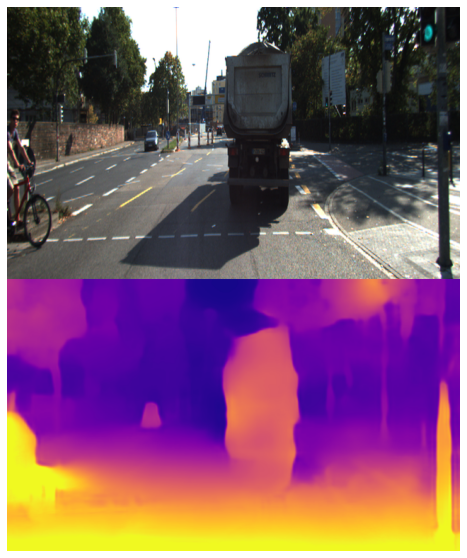

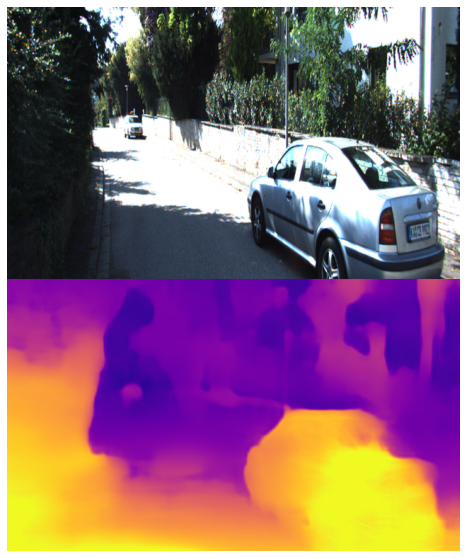

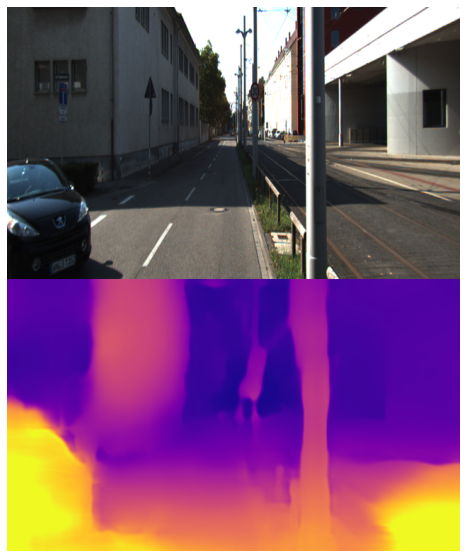

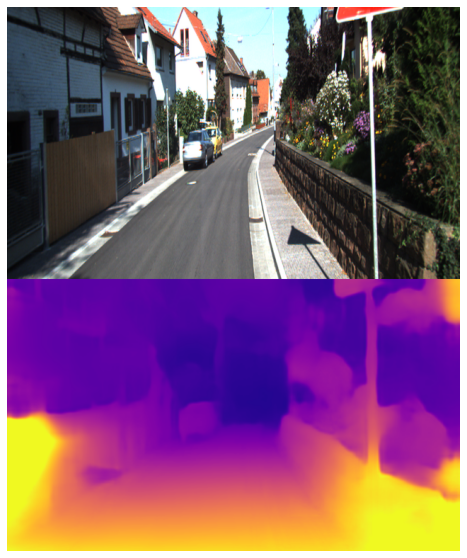

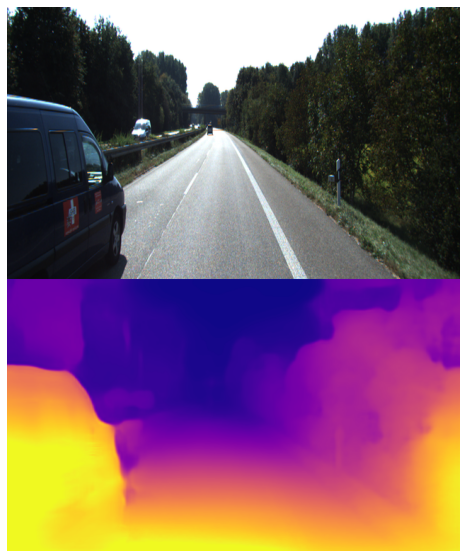

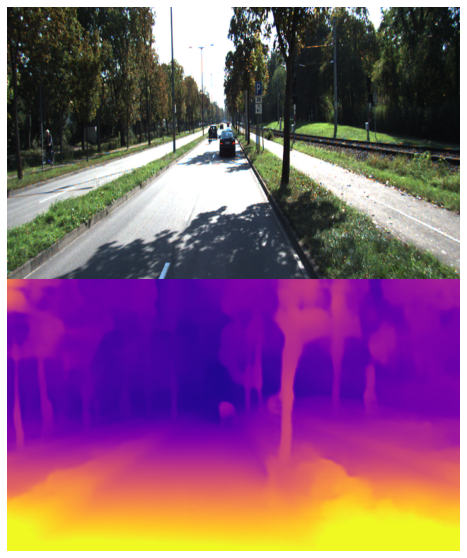

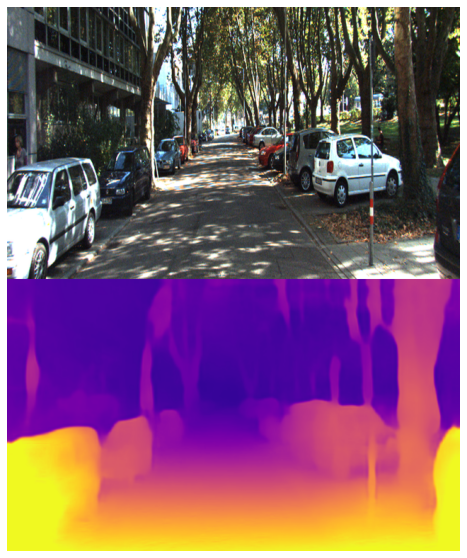

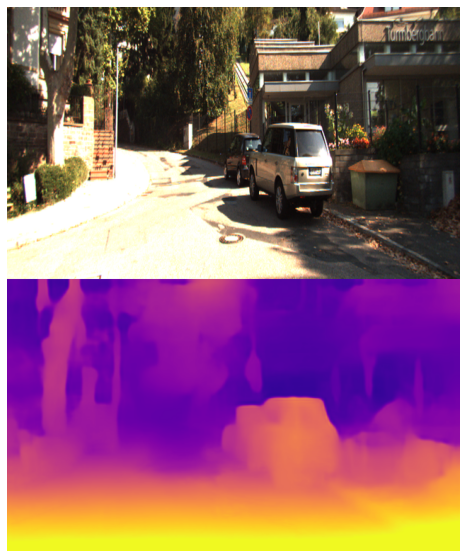

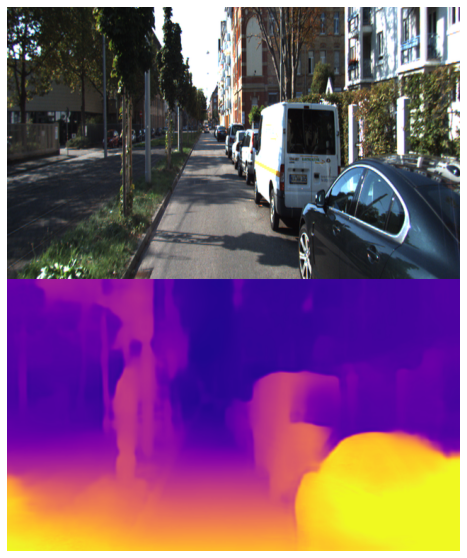

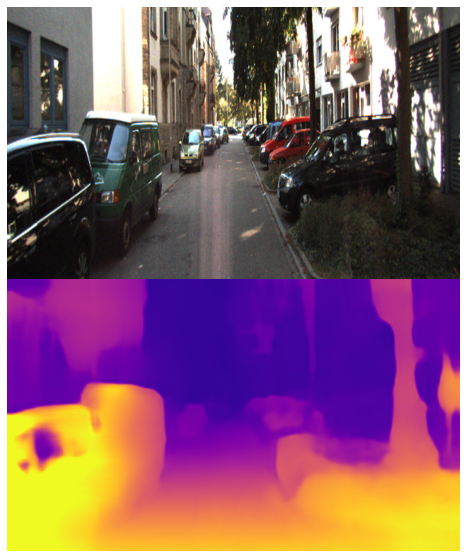

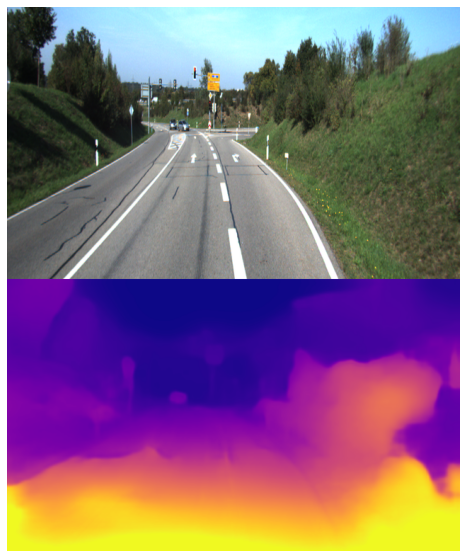

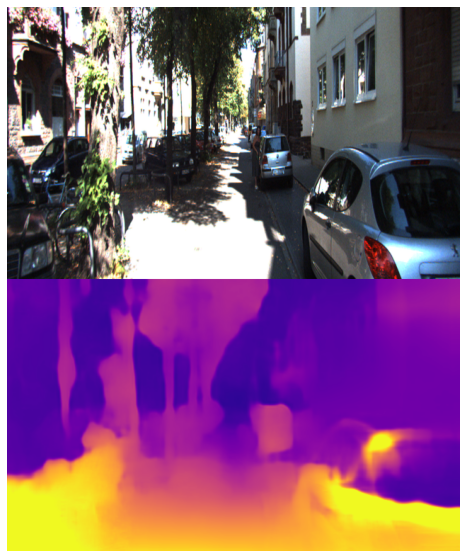

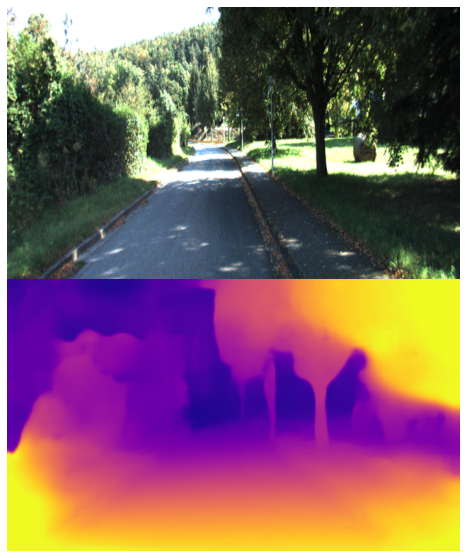

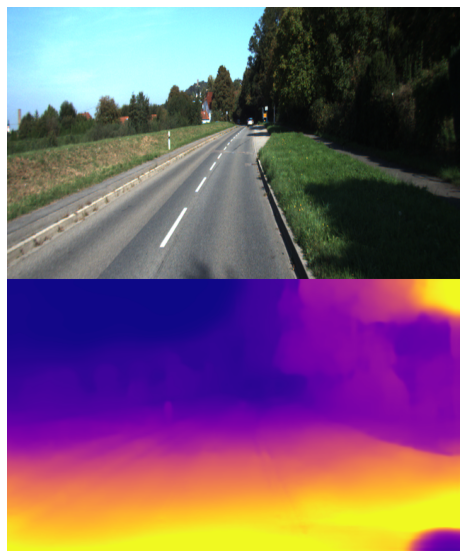

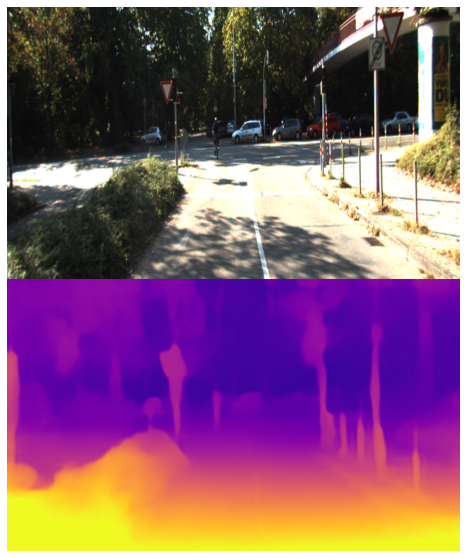

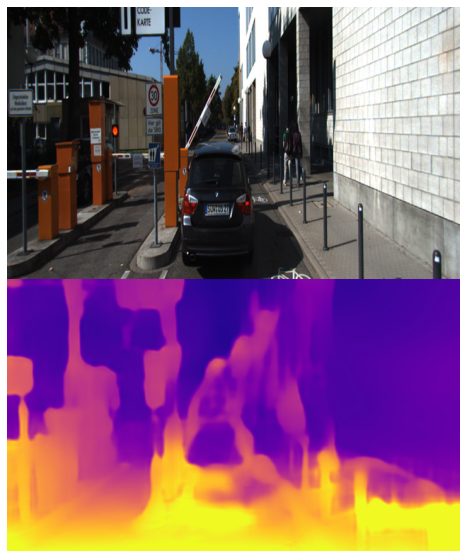

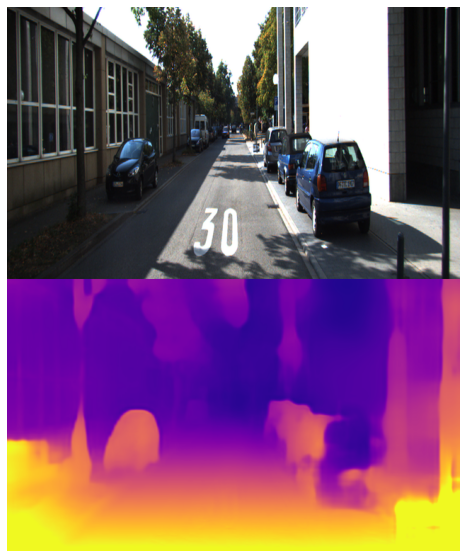

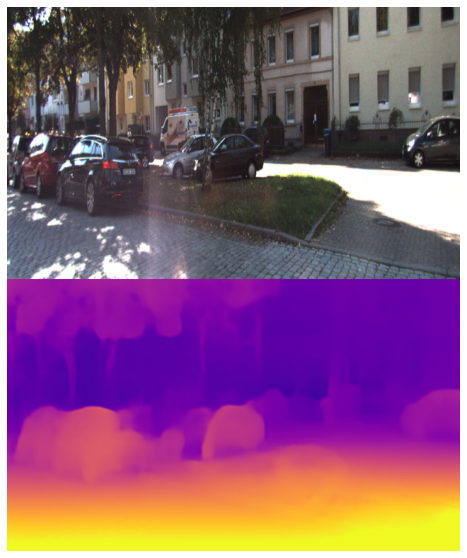

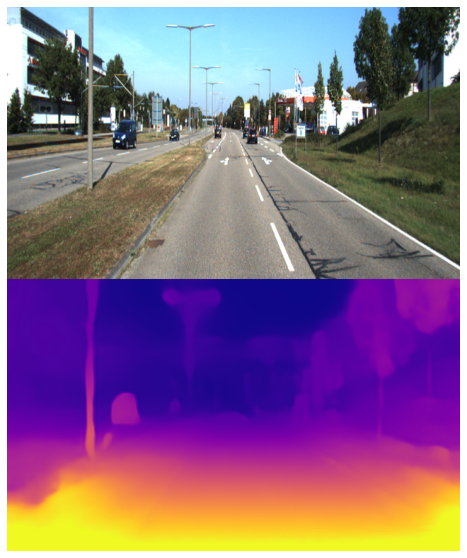

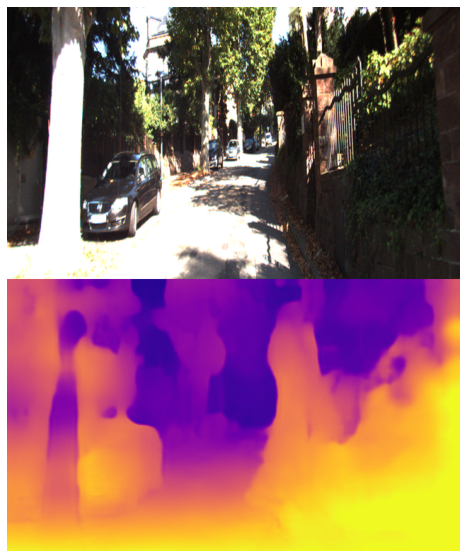

In [55]:
import matplotlib.pyplot as plt
import cv2

input_images_path = image_output_dir
items = os.listdir(input_images_path)    

for each_image in items:
  if each_image.endswith(".jpg") or each_image.endswith(".png"):
    print(each_image)
    full_path = input_images_path + '/' + each_image
    image = cv2.imread(full_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20, 10))
    plt.imshow(image)
    plt.grid(False)
    plt.axis('off')